# Explore Zillow

## Ingest

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/noahgift/real_estate_ml/master/data/Zip_Zhvi_SingleFamilyResidence_2018.csv")


## EDA

In [0]:
df.describe()

#### Clean Up DataFrame
Rename RegionName to ZipCode and Change Zip Code to String 

In [0]:
df.rename(columns={"RegionName":"ZipCode"}, inplace=True)
df["ZipCode"]=df["ZipCode"].map(lambda x: "{:.0f}".format(x))
df["RegionID"]=df["RegionID"].map(lambda x: "{:.0f}".format(x))
df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
0,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.000,335400.000,336500.000,...,1037400,1038700,1041500,1042800,1042900,1044400,1047800,1049700,1048300,1047900
1,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.000,212200.000,212200.000,...,330400,332700,334500,335900,337000,338300,338400,336900,336000,336500
2,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.000,500900.000,503100.000,...,1317900,1321100,1325300,1323800,1321200,1320700,1319500,1318800,1319700,1323300
3,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.000,77300.000,77300.000,...,120800,121300,122200,123000,123600,124500,125600,126300,126800,127400
4,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.000,95600.000,95800.000,...,175500,176400,176900,176900,177300,178000,178500,179300,180200,180700


In [0]:
median_prices = df.median()
#sf_prices = df["City"] == "San Francisco".median()


**Median USA Prices December, 2018**

In [0]:
median_prices.tail()

2018-08   196900.000
2018-09   198100.000
2018-10   199600.000
2018-11   201100.000
2018-12   202150.000
dtype: float64

In [0]:
sf_df = df[df["City"] == "San Francisco"].median()
df_comparison = pd.concat([sf_df,median_prices], axis=1)
df_comparison.columns = ["San Francisco","Median USA"]
df_comparison.head()

,San Francisco,Median USA
1996-04,306900.000,96500.000
1996-05,307600.000,96700.000
1996-06,308400.000,96750.000
1996-07,309300.000,96900.000
1996-08,310500.000,96900.000


In [0]:
df_comparison.reset_index()
df_comparison=df_comparison.drop([0,1,2],axis=0,inplace=True)
df_comparison.columns = ["Date","San Fransisco","Median USA"]
df_comparison=df_comparison.reset_index(drop=True)
df_comparison.head()

ValueError: ignored

In [0]:
df_comparison.index.name = 'Date'
df_comparison.columns.name = 'month'
df_comparison['Date'] = pd.to_datetime(df_comparison['Date'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = df_comparison.set_index(['Date'])
indexedDataset.head(5)

KeyError: ignored

In [0]:
df_comparison.index.name = 'date'
df_comparison.columns.name = 'month'



ValueError: ignored

In [0]:
data = pd.read_csv('forecast.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

      date  San Francisco  Median USA
0  1996-04     306900.000   96500.000
1  1996-05     307600.000   96700.000
2  1996-06     308400.000   96750.000
3  1996-07     309300.000   96900.000
4  1996-08     310500.000   96900.000

 Data Types:
date              object
San Francisco    float64
Median USA       float64
dtype: object


KeyError: ignored

In [0]:
from pandas import Series
from matplotlib import pyplot
# load dataset
series = Series(sf_df)
# display first few rows
print(series)
# line plot of dataset
series.plot()
pyplot.show()

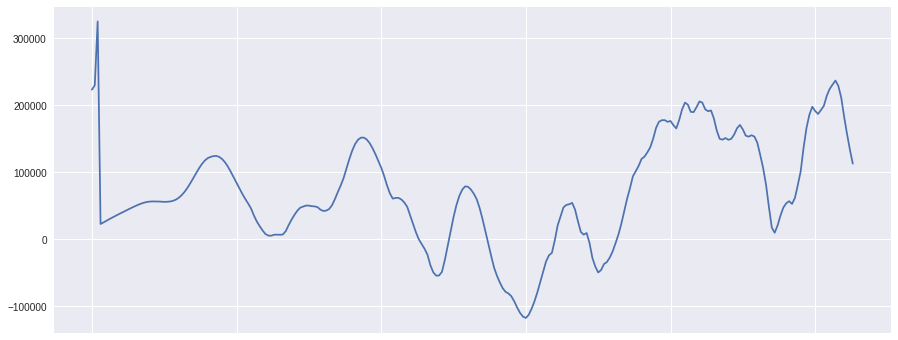

In [0]:
# seasonally adjust the time series
from pandas import Series
from matplotlib import pyplot
# load dataset
series = Series(sf_df)
# seasonal difference
differenced = series.diff(12)
# trim off the first year of empty data
differenced = differenced[12:]
# save differenced dataset to file
differenced.to_csv('seasonally_adjusted.csv')
# plot differenced dataset
differenced.plot()
pyplot.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


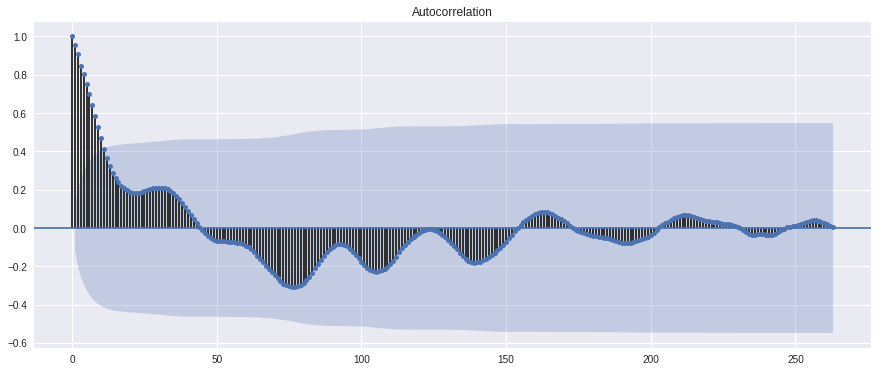

In [0]:
#auto-correlation
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
series = Series.from_csv('seasonally_adjusted.csv', header=None)
plot_acf(series)
pyplot.show()

In [0]:
#t-1 observation
from pandas import Series
from pandas import DataFrame
# load dataset
series = Series.from_csv('seasonally_adjusted.csv', header=None)
# reframe as supervised learning
dataframe = DataFrame()
for i in range(12,0,-1):
 dataframe['t-'+str(i)] = series.shift(i)
dataframe['t'] = series.values
print(dataframe.head(13))
dataframe = dataframe[13:]
# save to new file
dataframe.to_csv('lags_12months_features.csv', index=False)

                 t-12       t-11       t-10        t-9        t-8        t-7  \
1997-01-01        nan        nan        nan        nan        nan        nan   
1997-02-01        nan        nan        nan        nan        nan        nan   
1997-03-01        nan        nan        nan        nan        nan        nan   
1997-04-01        nan        nan        nan        nan        nan        nan   
1997-05-01        nan        nan        nan        nan        nan        nan   
1997-06-01        nan        nan        nan        nan        nan        nan   
1997-07-01        nan        nan        nan        nan        nan        nan   
1997-08-01        nan        nan        nan        nan        nan 223428.000   
1997-09-01        nan        nan        nan        nan 223428.000 229782.000   
1997-10-01        nan        nan        nan 223428.000 229782.000 325285.000   
1997-11-01        nan        nan 223428.000 229782.000 325285.000  22700.000   
1997-12-01        nan 223428.000 229782.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


[1.91675088e-03 1.29930442e-03 1.15642817e-03 8.78582225e-04
 1.09228376e-03 1.01921450e-03 9.86036295e-04 1.28608494e-03
 1.51821302e-03 1.34710326e-03 2.26438984e-03 9.85235609e-01]


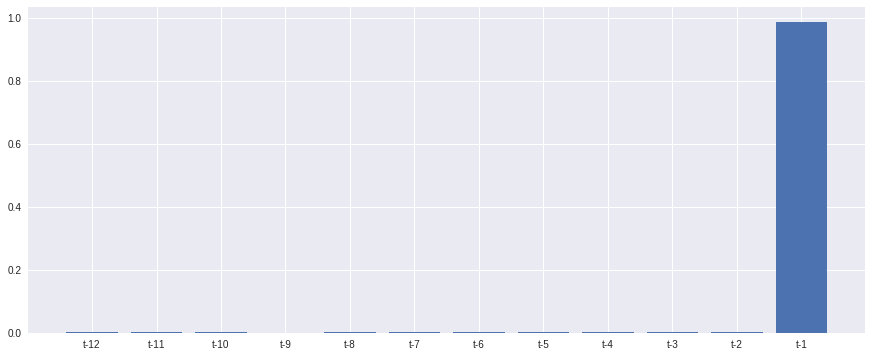

In [0]:
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load data
dataframe = read_csv('lags_12months_features.csv', header=0)
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

Selected Features:
t-12
t-8
t-4
t-1


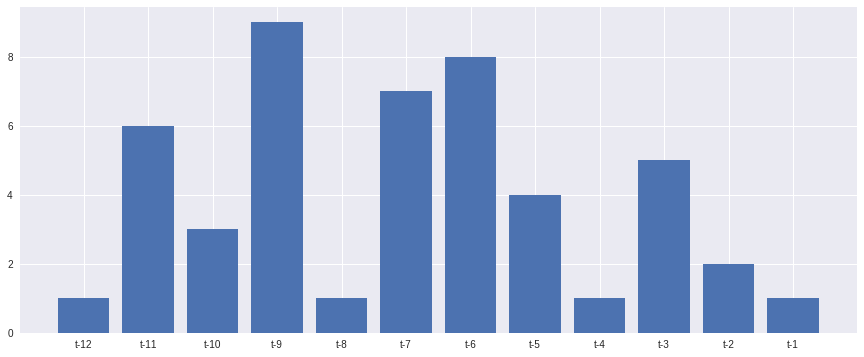

In [0]:
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load dataset
dataframe = read_csv('lags_12months_features.csv', header=0)
# separate into input and output variables
array = dataframe.values
X = array[:,0:-1]
y = array[:,-1]
# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 4)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
 if fit.support_[i]:
  print(names[i])
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()

In [0]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

NameError: ignored